In [1]:
import tensorflow as tf
import os

gpus = tf.config.experimental.list_physical_devices('CPU')

In [2]:
gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Remove Bad Images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = "data"

In [6]:
os.listdir(data_dir)

['arch', 'suspension']

In [7]:
image_exts = ['jpeg','jpg','bmp','png']

In [8]:
image_exts

['jpeg', 'jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir, image_class,image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

## Load Data

In [10]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 800 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
batch = data_iterator.next()

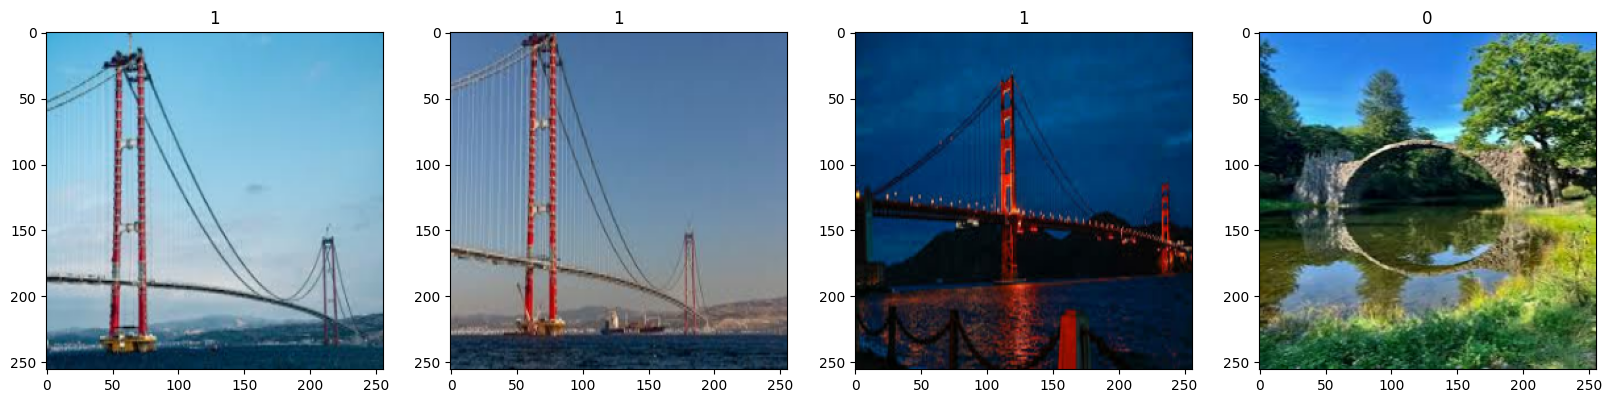

In [15]:
#class 1: suspended, class 0: arch
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [16]:
scaled = batch[0]/255
scaled.max()

1.0

In [17]:
data = data.map(lambda x,y: (x/255,y))

In [18]:
scaled_iterator = data.as_numpy_iterator()

In [19]:
batch = scaled_iterator.next()

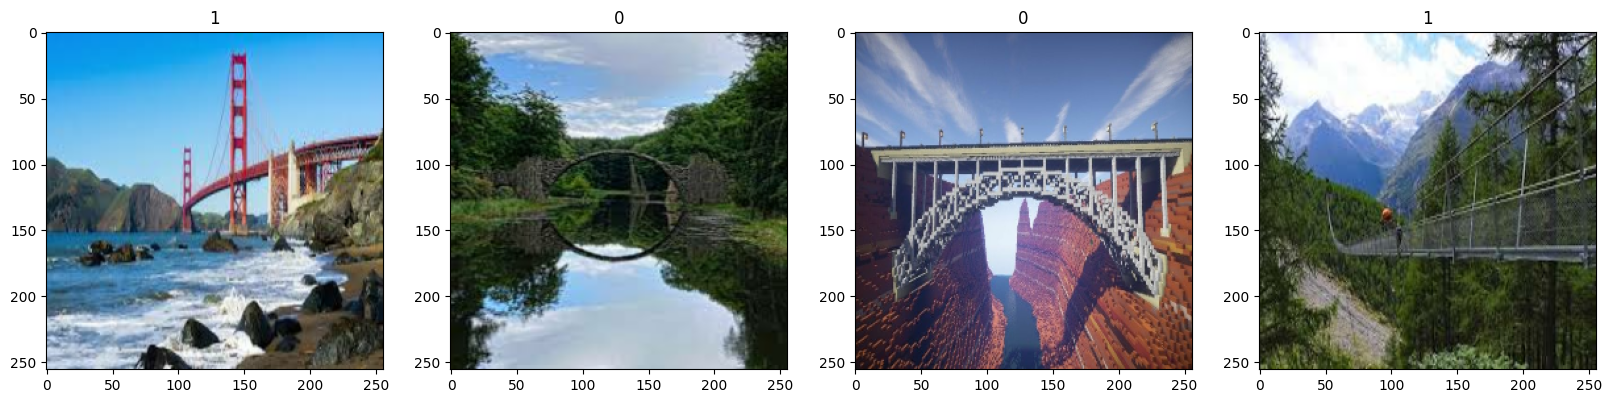

In [20]:
#class 1: suspended, class 0: arch
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## Split Data

In [21]:
len(data)

25

In [22]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.1)+1

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Deep Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\lelin\anaconda3\envs\tf_gpu\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [25]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4689 - loss: 0.7542 - val_accuracy: 0.5521 - val_loss: 0.6900
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 856ms/step - accuracy: 0.5237 - loss: 0.6914 - val_accuracy: 0.5469 - val_loss: 0.7104
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 870ms/step - accuracy: 0.5435 - loss: 0.7005 - val_accuracy: 0.6458 - val_loss: 0.6523
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 912ms/step - accuracy: 0.6294 - loss: 0.6371 - val_accuracy: 0.6667 - val_loss: 0.6444
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 727ms/step - accuracy: 0.6473 - loss: 0.6211 - val_accuracy: 0.6458 - val_loss: 0.6222
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 767ms/step - accuracy: 0.6474 - loss: 0.6208 - val_accuracy: 0.6198 - val_loss: 0.6094
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 753ms/step - accuracy: 0.7132 - loss: 0.5593 - val_accuracy: 0.7656 - val_loss: 0.5371
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 974ms/step - accuracy: 0.7787 - loss: 0.4521 - val_accurac

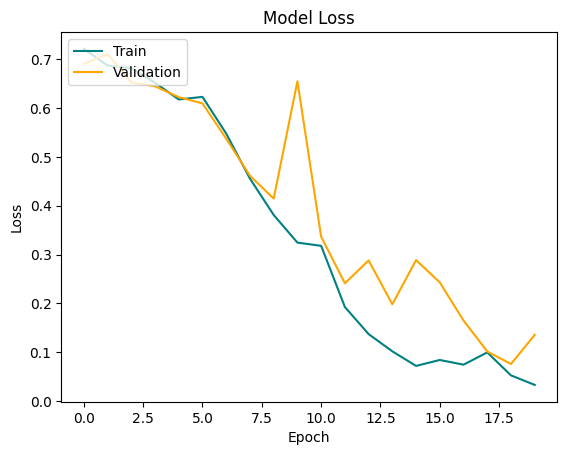

In [30]:
figt = plt.figure()
plt.plot(hist.history['loss'], color ='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

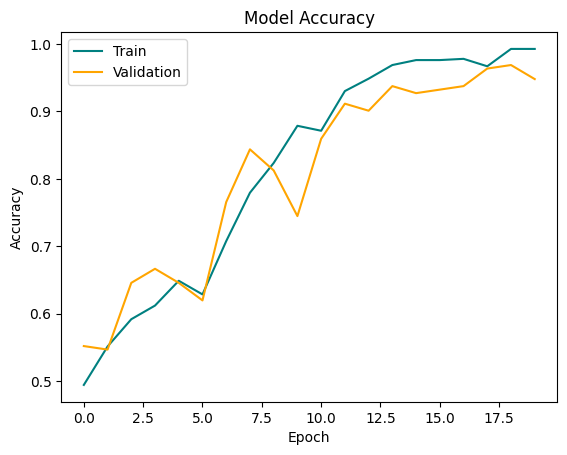

In [31]:
figt = plt.figure()
plt.plot(hist.history['accuracy'], color ='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluate Performance

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


In [35]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9714286, shape=(), dtype=float32) tf.Tensor(0.984375, shape=(), dtype=float32)


## Test

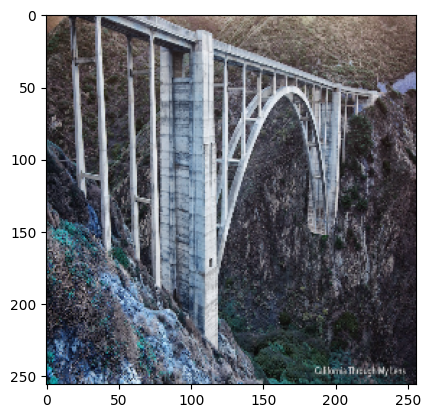

In [36]:
img = cv2.imread('arch_test.jpg')
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [37]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [38]:
resize.shape

TensorShape([256, 256, 3])

In [39]:
test1 = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


In [40]:
test1

array([[0.2798247]], dtype=float32)

In [41]:
if test1 > 0.5: 
    print(f'The bridge is of Suspension type')
else:
    print(f'The bridge is of Arch type')

The bridge is of Arch type


## Save the Model

from tensorflow.keras.models import load_model

In [51]:
from tensorflow.keras.models import load_model
model.save(os.path.join('model','bridgemodel.h5'))

In [52]:
new_model = load_model(os.path.join('model','bridgemodel.h5'))

In [53]:
test2 = new_model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


In [54]:
test2

array([[0.9999979]], dtype=float32)

In [55]:
if test2 > 0.5: 
    print(f'The bridge is of Suspension type')
else:
    print(f'The bridge is of Arch type')

The bridge is of Suspension type
